In [13]:
from dwave.system.composites import EmbeddingComposite
from dwave.system.samplers import DWaveSampler
import numpy as np
from pyqubo import Spin
import dimod
import neal
import time
import dwave.inspector
import matplotlib.pyplot as plt    
from greedy import SteepestDescentSolver

### Solving Max2SAT with Dwave (ising_model)

In [14]:
#Reading SAT problem (in CNF)
def pedir_problema_SAT(ruta):
    lineas = []
    with open(ruta, "r") as entrada:
        lineas = entrada.readlines()
    return lineas

In [15]:
#Obtaining lines from SAT problem
ruta = "s2v140c1600-5.cnf"
lineas = pedir_problema_SAT(ruta)

In [16]:
#From lines to clauses
def parsear_cnf(lineas):
    #Filter no comments lines
    lineas_clausulas = [linea.strip() for linea in lineas if not linea.startswith('c') and not linea.startswith('p')]

    #Assign each line to a clause
    clausulas = [list(map(int, linea.split()[:-1])) for linea in lineas_clausulas]

    return clausulas

clauses = parsear_cnf(lineas)

In [17]:
#Identify x_n of the SAT problem and creatinc empty h, J
b = int(list(lineas[2].split(" "))[2])
J = {}
h = {i: 0 for i in range(b)}

In [18]:
print(b)

140


In [19]:
#Create only the necessary J
def act_J(J, i, j, valor):
    if (i, j) in J:
        # Si la interacción ya existe, sumar el valor al existente
        J[(i, j)] += valor
    else:
        # Si la interacción no existe, agregarla al diccionario
        J[(i, j)] = valor

In [20]:
#Determine the sign of the variable, v={-1,0,1}, and assign values to h, J
for clause in clauses:
    for literal in clause:
        if literal > 0:
            h[np.abs(literal)-1] -= 1/4
        else:
            h[np.abs(literal)-1] += 1/4
    if clause[0]*clause[1] > 0:
        if np.abs(clause[0])>np.abs(clause[1]):
            act_J(J, np.abs(clause[1])-1, np.abs(clause[0])-1, 1/4)
        else:
            act_J(J, np.abs(clause[0])-1, np.abs(clause[1])-1, 1/4)
    else:
        if np.abs(clause[0])>np.abs(clause[1]):
            act_J(J, np.abs(clause[1])-1, np.abs(clause[0])-1, -1/4)
        else:
            act_J(J, np.abs(clause[0])-1, np.abs(clause[1])-1, -1/4)

print(h) #We can get an idea only with h

{0: 0.75, 1: -0.5, 2: 1.5, 3: -0.5, 4: 0.5, 5: -0.5, 6: 0.5, 7: -0.75, 8: 0.5, 9: 0.0, 10: -2.5, 11: -0.5, 12: -1.0, 13: 1.0, 14: 0.25, 15: -0.5, 16: 0.5, 17: -0.5, 18: 0.25, 19: 0.5, 20: -0.25, 21: 1.0, 22: 0.75, 23: -1.75, 24: 0.25, 25: 1.0, 26: 0.25, 27: -2.5, 28: 1.5, 29: 1.5, 30: -0.75, 31: -1.25, 32: 0.0, 33: 2.0, 34: -1.25, 35: 1.0, 36: 0.5, 37: -0.75, 38: 0.25, 39: 0.0, 40: -2.75, 41: 1.25, 42: -0.5, 43: 1.0, 44: 1.0, 45: -0.75, 46: 2.25, 47: 0.0, 48: -2.0, 49: -1.75, 50: -0.75, 51: -1.25, 52: -1.0, 53: 1.25, 54: 1.5, 55: 1.5, 56: -1.25, 57: 0.75, 58: 0.0, 59: 0.25, 60: 0.5, 61: -0.5, 62: -1.5, 63: 1.0, 64: -0.5, 65: -0.75, 66: 0.0, 67: 0.25, 68: 1.25, 69: 0.25, 70: 1.5, 71: -0.75, 72: -0.75, 73: 0.25, 74: -1.5, 75: -2.0, 76: -0.25, 77: 0.0, 78: 1.25, 79: 0.0, 80: 2.0, 81: -1.0, 82: 0.25, 83: -1.25, 84: -1.0, 85: 0.25, 86: 0.25, 87: 1.5, 88: -0.75, 89: -1.0, 90: 0.5, 91: 2.5, 92: 0.25, 93: 0.75, 94: -0.5, 95: -1.5, 96: 0.5, 97: -1.0, 98: -0.5, 99: -0.5, 100: 1.25, 101: -1.5, 10

#### With Chimera

In [21]:
num_reads=3000
annealing_time = 100 #By deffault is 20 microsec
secure_q = input("Do you really want to use the QPU? (y/n)")
if secure_q == 'y' or secure_q == 'Y':
    #Define the topology
    sampler = EmbeddingComposite(DWaveSampler(token='Your token'))
    sample_set_chimera = sampler.sample_ising(h, J, num_reads=num_reads, return_embedding=True)
    print("Using DWaveSampler()")
    print(sample_set_chimera)

Do you really want to use the QPU? (y/n) y


Using DWaveSampler()
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 139 energy num_oc. ...
0    +1 +1 -1 -1 -1 -1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  -1 -170.0       1 ...
4    +1 +1 -1 -1 -1 -1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  -1 -169.0       1 ...
1    +1 -1 -1 -1 -1 -1 +1 -1 -1 +1 +1 -1 -1 -1 +1 +1 ...  +1 -168.0       1 ...
6    +1 -1 -1 +1 +1 -1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  -1 -168.0       1 ...
27   +1 +1 -1 -1 +1 -1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  -1 -168.0       1 ...
2    +1 +1 -1 +1 -1 -1 +1 -1 -1 +1 +1 +1 -1 -1 +1 -1 ...  +1 -167.0       1 ...
13   -1 +1 -1 -1 +1 -1 +1 -1 -1 +1 +1 -1 -1 -1 +1 +1 ...  -1 -167.0       1 ...
22   +1 -1 -1 +1 -1 -1 +1 -1 -1 +1 +1 -1 -1 -1 +1 +1 ...  +1 -167.0       1 ...
28   -1 +1 -1 -1 +1 -1 +1 -1 -1 -1 +1 -1 -1 -1 +1 +1 ...  -1 -167.0       1 ...
48   -1 +1 -1 -1 +1 -1 +1 -1 -1 +1 +1 -1 -1 -1 +1 +1 ...  -1 -167.0       1 ...
157  +1 -1 -1 -1 -1 -1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  +1 -167.0       1 ...
7    -1 +1 -1 -1 +1

#### With Pegasus

In [26]:
secure_q = input("Do you really want to use the QPU? (y/n)")
if secure_q == 'y' or secure_q == 'Y':
    #Define the topology
    sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}, token='Your token'))
    sample_set_pegasus = sampler.sample_ising(h, J, num_reads=num_reads, return_embedding=True)
    print("Using DWaveSampler()")
    print(sample_set_pegasus)

Do you really want to use the QPU? (y/n) y


Using DWaveSampler()
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 139 energy num_oc. ...
30   +1 +1 -1 -1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  -1 -166.0       1 ...
14   +1 -1 -1 +1 -1 +1 -1 -1 +1 -1 +1 +1 -1 -1 -1 +1 ...  -1 -165.0       1 ...
21   +1 -1 -1 +1 -1 +1 +1 +1 -1 +1 +1 +1 -1 -1 +1 +1 ...  +1 -165.0       1 ...
0    +1 -1 -1 +1 +1 +1 -1 +1 -1 +1 +1 +1 -1 -1 -1 +1 ...  -1 -164.0       1 ...
1    +1 +1 -1 -1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  +1 -164.0       1 ...
9    +1 -1 -1 +1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 -1 +1 ...  -1 -164.0       1 ...
88   +1 -1 -1 +1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 -1 +1 ...  -1 -164.0       1 ...
5    +1 -1 -1 +1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 -1 +1 ...  -1 -163.0       1 ...
18   +1 +1 -1 -1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  +1 -163.0       1 ...
39   +1 +1 -1 -1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  -1 -163.0       1 ...
947  +1 -1 -1 +1 -1 +1 +1 -1 -1 +1 +1 +1 -1 -1 +1 +1 ...  -1 -163.0       1 ...
2    +1 -1 -1 +1 -1

#### With Zephyr

In [ ]:
secure_q = input("Do you really want to use the QPU? (y/n)")
if secure_q == 'y' or secure_q == 'Y':
    #Define the topology
    sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'zephyr'}, token='Your token'))
    sample_set_zephyr = sampler.sample_ising(h, J, num_reads=num_reads, return_embedding=True)
    print("Using DWaveSampler()")
    print(sample_set_zephyr)

#### QPU access time (time used by de QPU: configuration and solving)

In [41]:
topologies = [sample_set_chimera, sample_set_pegasus]
top_name = ['chimera', 'pegasus']
i=0
for sample_set in topologies:
    qpu_access_time = sample_set.info['timing']['qpu_access_time']
    #Tiempo usado por la QPU para resolver el problema de forma activa
    qpu_sampling_time = sample_set.info['timing']['qpu_sampling_time']
    print("For topology ", top_name[i])
    i+=1
    print("Using DWave QPU... QPU access time:", qpu_access_time*10**(-6), "s.", " ; QPU sampling time:", qpu_sampling_time*10**(-6), "s.")

For topology  chimera
Using DWave QPU... QPU access time: 0.78699917 s.  ; QPU sampling time: 0.7712399999999999 s.
For topology  pegasus
Using DWave QPU... QPU access time: 0.58575277 s.  ; QPU sampling time: 0.56982 s.


#### Count unsatisfied clauses for each assignment and change the format of the results

In [42]:
def count_unsatisfied_clauses(assignment, clauses):
    count = 0
    for clause in clauses:
        for literal in clause:
            if (literal > 0 and assignment[literal - 1] == 1) or (literal < 0 and assignment[-literal - 1] == -1):
                count += 1
                break
    return str(len(clauses)-count)

In [43]:
#Change of the format
def convert_to_format(result):
    return ''.join('1' if result[v] == 1 else '0' for v in result)

In [44]:
#Open file and write solutions
i=0
for sample_set in topologies:
    output_file = f"{ruta}.{top_name[i]}.dwave.sol"
    with open(output_file, 'w') as output_file:
        qpu_access_time = sample_set.info['timing']['qpu_access_time']
        #Tiempo usado por la QPU para resolver el problema de forma activa
        qpu_sampling_time = sample_set.info['timing']['qpu_sampling_time']
        output_file.write(f"Total time the QPU has spent processing the problem (qpu_access_time): {qpu_access_time*10**(-6)} segundos\n"
        f"Total time the QPU has spent on active resolution (qpu_sampling_time): {qpu_sampling_time*10**(-6)} segundos\n")
        print("Using DWave QPU... QPU access time:", qpu_access_time*10**(-6), "s.", " ; QPU sampling time:", qpu_sampling_time*10**(-6), "s.")
        for assignment in sample_set:
            formatted_result = convert_to_format(assignment)
            unsatisfied = count_unsatisfied_clauses(assignment, clauses)
            output_file.write('o ' + unsatisfied + '\n' + 'v ' + formatted_result + '\n')
    i+=1
    print(f'Soluciones guardadas en {output_file}')

Using DWave QPU... QPU access time: 0.78699917 s.  ; QPU sampling time: 0.7712399999999999 s.
Soluciones guardadas en <_io.TextIOWrapper name='s2v140c1600-5.cnf.chimera.dwave.sol' mode='w' encoding='UTF-8'>
Using DWave QPU... QPU access time: 0.58575277 s.  ; QPU sampling time: 0.56982 s.
Soluciones guardadas en <_io.TextIOWrapper name='s2v140c1600-5.cnf.pegasus.dwave.sol' mode='w' encoding='UTF-8'>


#### Minor Embedding

In [49]:
i=0
for sample_et in topologies:
    print("For topology ", top_name[i])
    print("Chain stregnth: ", sample_set.info["embedding_context"]["chain_strength"])
    chains = sample_set.info["embedding_context"]["embedding"].values()  
    print("Max chain length: ", max(len(chain) for chain in chains))
    print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(
        np.count_nonzero(sample_set.record.chain_break_fraction > 0.10)/num_reads*100,
        np.count_nonzero(sample_set.record.chain_break_fraction > 0.0)/num_reads*100))
    i+=1

For topology  chimera
Chain stregnth:  1.6900532535988326
Max chain length:  23
Percentage of samples with >10% breaks is 0.0 and >0 is 99.63333333333333.
For topology  pegasus
Chain stregnth:  1.6900532535988326
Max chain length:  23
Percentage of samples with >10% breaks is 0.0 and >0 is 99.63333333333333.


In [52]:
dwave.inspector.show(sample_set_chimera)

Serving Inspector on http://127.0.0.1:18000/?problemId=5127ea6c-84d7-4fb7-812a-3deee3a709d9

'http://127.0.0.1:18000/?problemId=5127ea6c-84d7-4fb7-812a-3deee3a709d9'

#### Chain length statistics

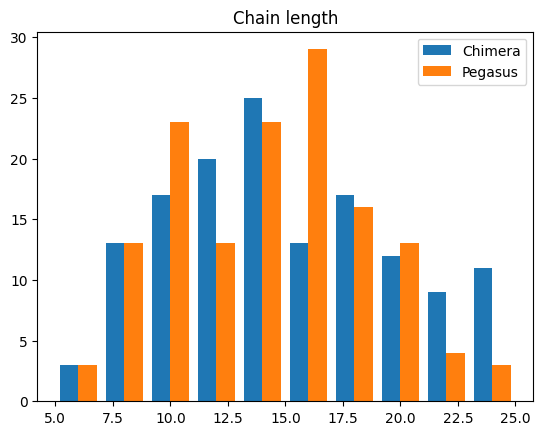

In [54]:
chain_stat=[]
for sample_set in topologies:
    chain_len=[]
    chains = sample_set.info["embedding_context"]["embedding"].values()
    for chain in chains:
        chain_len.append(len(chain))
    chain_stat.append(chain_len)

plt.hist(chain_stat, label=['Chimera', 'Pegasus'])
plt.title('Chain length')
plt.legend()

#### Time to get the best solution

In [112]:
best_solution = sample_set.first.sample
best_time = sample_set.first.timestamp
best_energy = sample_set.first.energy
print("The optimal solution is with optimum: ",count_unsatisfied_clauses(best_energy, clauses) , "\n Has been found in time: ", best_time*10**(-6))

IndexError: invalid index to scalar variable.

In [111]:
best_solution = None
best_energy = float('inf')
best_time = None

for sample in sample_set.samples():
    energy = sample_set.record.energy[sample]
    time = sample_set.record.timestamp[sample]
    
    if energy < best_energy:
        best_energy = energy
        best_solution = sample
        best_time = time

print("The optimal solution is with optimum: ",count_unsatisfied_clauses(best_energy, clauses) , "\n Has been found in time: ", best_time*10**(-6))

AttributeError: recarray has no attribute timestamp

#### Post processing

Time for Post-processing: 0.02 s.


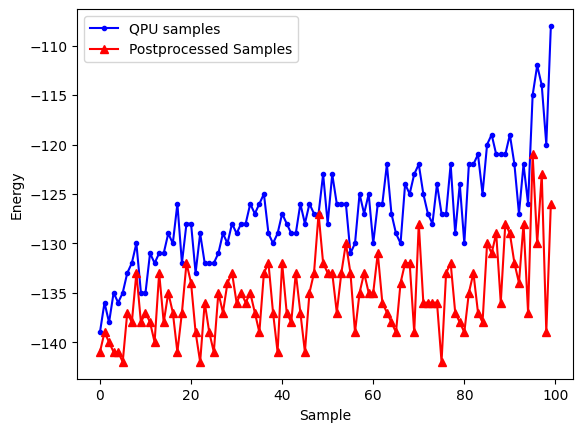

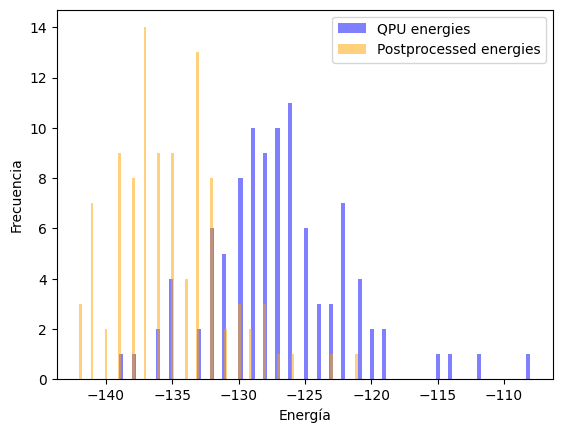

Soluciones guardadas en <_io.TextIOWrapper name='PP.s2v120c1500-5.cnf.nr.100.dwave.sol' mode='w' encoding='UTF-8'>


In [16]:
solver_greedy = SteepestDescentSolver()
start_time = time.time()
sampleset_pp = solver_greedy.sample_ising(h, J, initial_states=sample_set)
end_time = time.time()

print("Time for Post-processing:", round(end_time-start_time, 2), "s.")

plt.plot(list(range(100)), sample_set.record.energy, 'b.-',
                           sampleset_pp.record.energy, 'r^-') 
plt.legend(['QPU energies', 'Postprocessed energies'])          
plt.xlabel("Sample")    
plt.ylabel("Energy")    
plt.show()

plt.hist(sample_set.record.energy, bins=100, alpha=0.5, color='blue', label='QPU energies')
plt.hist(sampleset_pp.record.energy, bins=100, alpha=0.5, color='orange', label='Postprocessed energies')
plt.xlabel('Energía')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

#Abre el archivo para escribir las soluciones
output_file = f"PP.{ruta}.nr.{num_read}.dwave.sol"
with open(output_file, 'w') as output_file:
    #Escribimos el tiempo que ha tardado en resolver el problema
    output_file.write(f"Total time the QPU has spent processing the problem (qpu_access_time): {qpu_access_time*10**(-6)} segundos\n"
    f"Total time the QPU has spent on active resolution (qpu_sampling_time): {qpu_sampling_time*10**(-6)} segundos\n"
    f"Total time for QPU and Post-processing: {qpu_access_time*10**(-6)+round(end_time-start_time, 2)} segundos\n")
    
    #Recorre los resultados y escribe cada uno en el archivo
    for assignment in sampleset_pp:
        formatted_result = convert_to_format(assignment)
        unsatisfied = count_unsatisfied_clauses(assignment, clauses)
        output_file.write('o ' + unsatisfied + '\n' + 'v ' + formatted_result + '\n')

print(f'Soluciones guardadas en {output_file}')

### Using simulated annealing

In [29]:
ising_model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.Vartype.SPIN)
sampler = neal.SimulatedAnnealingSampler()
start_time = time.time()
response = sampler.sample(ising_model, num_reads=100)
end_time = time.time()

print("Using SimulatedAnnlearingSampler()... Time:", round(end_time-start_time, 2), "s.")

for sample, energy in response.data(['sample', 'energy']):
    formatted_result = convert_to_format(sample)
    unsatisfied = count_unsatisfied_clauses(sample, clauses)
    print(formatted_result, energy, unsatisfied)

Using SimulatedAnnlearingSampler()... Time: 0.82 s.
000001001001001111011001100101100010001000001011111000011011001110000111101001000010000111000011111110001011000101100110 -142.0 233
000001001001001111011001100101100110000000001011010000011011001110000111101001000010000111000011011110001011000101100110 -142.0 233
000001001001001111011001100101100110000000001011010000011011001110000111101001000010000111000011011110001011000101100110 -142.0 233
000001001001001111011001100101100110000000001011110000011011001110000111101001000010000111000011011110001011000101100110 -142.0 233
000001001001001111011001100101100010000000001011111000011011001110000111101001000010000111000011111110001011000101100110 -142.0 233
000001001001001111011001100101100110000000001011011000011011001110000111101001000010000111000011011110001011000101100110 -142.0 233
000001001001001111011001100101100110001000001011111000011011001110000111101001000010000111000011111110001011000101100110 -142.0 233
000001001001001111011001